# Oxford-IIIT Pet — Semantic Segmentation (PyTorch)
Este caderno realiza **segmentação semântica** no dataset **Oxford-IIIT Pet** usando **UNet** (PyTorch), com:
- **subset** do dataset para treino rápido
- métricas **IoU** e **Acurácia** via `torchmetrics`
- visualização de exemplos (máscara sobreposta)
- exportação do modelo em **TorchScript FP32** (para uso em conversão posterior para ONNX/TFLite)

In [9]:

!pip -q install torchmetrics==1.4.0.post0 matplotlib opencv-python

In [10]:

import os, math, random, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet as OxPet
from torchvision.transforms import InterpolationMode
from torchmetrics.classification import BinaryJaccardIndex, BinaryAccuracy
from torchvision.transforms import functional as TF
from pathlib import Path

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 256
BATCH = 8
EPOCHS = 20
SUB_TRAIN = 100
SUB_VAL = 50

## Download dos dados

In [11]:

data_dir = Path("/content/data")
data_dir.mkdir(parents=True, exist_ok=True)

ds_trainval = OxPet(
    root=str(data_dir),
    split="trainval",
    target_types="segmentation",
    download=True,
)
len(ds_trainval)

3680

## Preparo dos Dados

In [12]:

to_tensor = transforms.ToTensor()
img_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=InterpolationMode.BILINEAR),
    transforms.ToTensor(),
])

def binarize_mask(mask_pil):
    mask_resized = TF.resize(mask_pil, (IMG_SIZE, IMG_SIZE), interpolation=InterpolationMode.NEAREST)
    m = np.array(mask_resized, dtype=np.uint8)
    m_bin = ((m == 1) | (m == 3)).astype(np.float32)
    return torch.from_numpy(m_bin).unsqueeze(0)


class PetSeg(torch.utils.data.Dataset):
    def __init__(self, base):
        self.base = base
        self._resize_nearest = lambda im: TF.resize(
            im, (IMG_SIZE, IMG_SIZE), interpolation=InterpolationMode.NEAREST
        )

    def __len__(self):
        return len(self.base)

    def __getitem__(self, i):
        img, mask = self.base[i]
        img  = img_tf(img)
        mask = self._resize_nearest(mask)
        mask = binarize_mask(mask)
        return img, mask

gen = torch.Generator().manual_seed(42)
n_total = len(ds_trainval)
n_train = min(SUB_TRAIN, n_total)
n_val   = min(SUB_VAL, max(0, n_total - n_train))

base_train, base_val, *_ = torch.utils.data.random_split(
    ds_trainval, [n_train, n_val, n_total - (n_train + n_val)], generator=gen
)

ds_train = PetSeg(base_train)
ds_val   = PetSeg(base_val)
dl_train = DataLoader(ds_train, batch_size=BATCH, shuffle=True,
                      num_workers=2, pin_memory=(DEVICE.type == "cuda"))
dl_val   = DataLoader(ds_val,   batch_size=BATCH, shuffle=False,
                      num_workers=2, pin_memory=(DEVICE.type == "cuda"))
xb, yb = next(iter(dl_train))
xb.shape, yb.shape

(torch.Size([8, 3, 256, 256]), torch.Size([8, 1, 256, 256]))

## Construção e Treinamento do Modelo

In [13]:

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.block(x)

class UNetSmall(nn.Module):
    def __init__(self, in_ch: int = 3, out_ch: int = 1, base: int = 32):
        super().__init__()
        self.enc = nn.ModuleList([
            DoubleConv(in_ch, base),
            DoubleConv(base, base*2),
            DoubleConv(base*2, base*4),
            DoubleConv(base*4, base*8),
        ])
        self.pools = nn.ModuleList([nn.MaxPool2d(2) for _ in range(4)])
        self.bottleneck = DoubleConv(base*8, base*16)

        self.up = nn.ModuleList([
            nn.ConvTranspose2d(base*16, base*8, kernel_size=2, stride=2),
            nn.ConvTranspose2d(base*8,  base*4, kernel_size=2, stride=2),
            nn.ConvTranspose2d(base*4,  base*2, kernel_size=2, stride=2),
            nn.ConvTranspose2d(base*2,  base,    kernel_size=2, stride=2),
        ])
        self.dec = nn.ModuleList([
            DoubleConv(base*16, base*8),
            DoubleConv(base*8,  base*4),
            DoubleConv(base*4,  base*2),
            DoubleConv(base*2,  base),
        ])

        self.head = nn.Conv2d(base, out_ch, kernel_size=1)

    def forward(self, x):
        skips = []
        h = x
        for i in range(4):
            h = self.enc[i](h)
            skips.append(h)
            h = self.pools[i](h)
        h = self.bottleneck(h)
        for i in range(4):
            h = self.up[i](h)
            h = torch.cat([h, skips[-(i+1)]], dim=1)
            h = self.dec[i](h)

        return self.head(h)

model = UNetSmall().to(DEVICE)
sum(p.numel() for p in model.parameters())/1e6

7.765985

In [14]:
import os, copy, json

for _dir in ("checkpoints", "export"):
    os.makedirs(_dir, exist_ok=True)

def estimate_pos_weight(dataloader, max_batches: int = 20):
    pos = 0.0
    total = 0

    for i, (_, m) in enumerate(dataloader, start=1):
        mb = (m > 0.5).to(dtype=m.dtype)
        pos += mb.sum().item()
        total += mb.numel()
        if max_batches is not None and i >= max_batches:
            break
    neg = max(total - pos, 0.0)
    return float(max(neg / max(pos, 1.0), 1.0))

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

pos_w_val = float(estimate_pos_weight(dl_train))
pos_w = torch.tensor([pos_w_val], device=DEVICE)
print(f"pos_weight ~ {pos_w.item():.2f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_w)

def _run_phase(dataloader, train: bool, threshold: float = 0.5):
    model.train(train)

    iou_metric = BinaryJaccardIndex().to(DEVICE)
    acc_metric = BinaryAccuracy().to(DEVICE)

    total_loss = 0.0
    total_samples = 0

    for imgs, masks in dataloader:
        imgs  = imgs.to(DEVICE, non_blocking=True)
        masks = masks.to(DEVICE, non_blocking=True)
        logits = model(imgs)
        loss = criterion(logits, masks)

        if train:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

        bs = imgs.size(0)
        total_loss += loss.item() * bs
        total_samples += bs

        with torch.no_grad():
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).to(torch.int)
            iou_metric.update(preds, masks.to(torch.int))
            acc_metric.update(preds, masks.to(torch.int))

    avg_loss = total_loss / max(total_samples, 1)
    iou = float(iou_metric.compute().item())
    acc = float(acc_metric.compute().item())
    return avg_loss, iou, acc

def train_one_epoch():
    return _run_phase(dl_train, train=True)

@torch.no_grad()
def validate_one_epoch():
    return _run_phase(dl_val, train=False)

def save_epoch_ckpt(epoch, val_iou, val_loss, path):
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "val_iou": float(val_iou),
        "val_loss": float(val_loss),
    }, path)

def save_best_state(path="checkpoints/best_unet.pth"):
    torch.save(copy.deepcopy(model.state_dict()), path)

best_iou = -1.0
best_epoch = -1
history = {"train": [], "val": []}

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_iou, tr_acc = train_one_epoch()
    va_loss, va_iou, va_acc = validate_one_epoch()

    history["train"].append((tr_loss, tr_iou, tr_acc))
    history["val"].append((va_loss, va_iou, va_acc))

    save_epoch_ckpt(epoch, va_iou, va_loss, f"checkpoints/ckpt_epoch_{epoch:02d}.pth")

    if va_iou > best_iou:
        best_iou = va_iou
        best_epoch = epoch
        save_best_state("checkpoints/best_unet.pth")

    print(
        f"Epoch {epoch:02d} | "
        f"train: loss={tr_loss:.4f}, IoU={tr_iou:.3f}, Acc={tr_acc:.3f} | "
        f"val: loss={va_loss:.4f}, IoU={va_iou:.3f}, Acc={va_acc:.3f} "
        f"(best IoU @ epoch {best_epoch}: {best_iou:.3f})"
    )


pos_weight ~ 1.29
Epoch 01 | train: loss=0.7762, IoU=0.297, Acc=0.586 | val: loss=1.9912, IoU=0.423, Acc=0.445 (best IoU @ epoch 1: 0.423)
Epoch 02 | train: loss=0.7287, IoU=0.429, Acc=0.623 | val: loss=0.7657, IoU=0.413, Acc=0.529 (best IoU @ epoch 1: 0.423)
Epoch 03 | train: loss=0.7223, IoU=0.427, Acc=0.634 | val: loss=0.7314, IoU=0.437, Acc=0.571 (best IoU @ epoch 3: 0.437)
Epoch 04 | train: loss=0.6736, IoU=0.487, Acc=0.678 | val: loss=0.6484, IoU=0.533, Acc=0.700 (best IoU @ epoch 4: 0.533)
Epoch 05 | train: loss=0.6283, IoU=0.549, Acc=0.728 | val: loss=0.6993, IoU=0.515, Acc=0.721 (best IoU @ epoch 4: 0.533)
Epoch 06 | train: loss=0.6109, IoU=0.542, Acc=0.733 | val: loss=0.6831, IoU=0.567, Acc=0.714 (best IoU @ epoch 6: 0.567)
Epoch 07 | train: loss=0.5880, IoU=0.574, Acc=0.742 | val: loss=0.8699, IoU=0.345, Acc=0.674 (best IoU @ epoch 6: 0.567)
Epoch 08 | train: loss=0.5764, IoU=0.571, Acc=0.753 | val: loss=0.5864, IoU=0.557, Acc=0.743 (best IoU @ epoch 6: 0.567)
Epoch 09 | tra

## Visualização dos Resultados

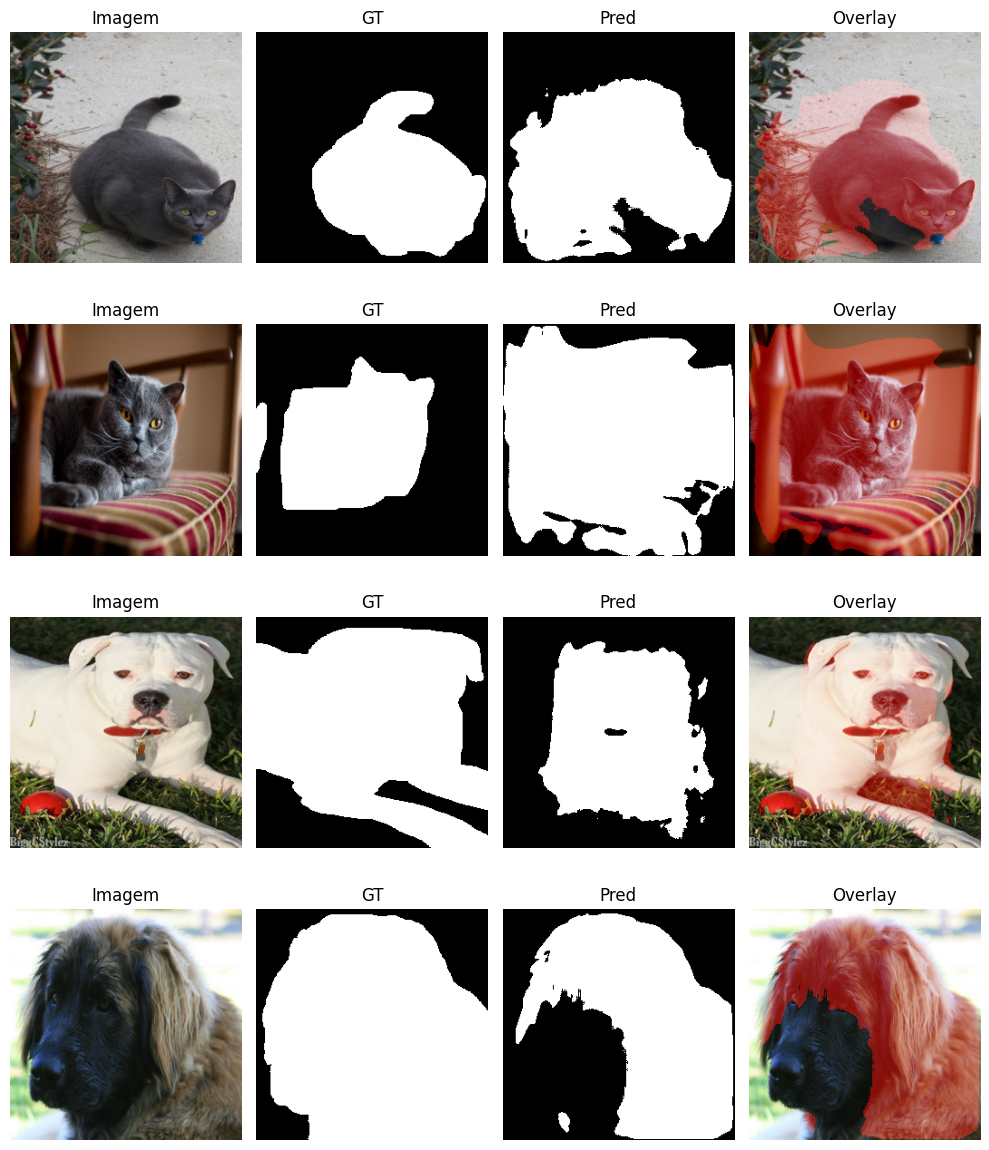

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch

@torch.no_grad()
def predict_batch(model, xb, thr=0.5):
    model.eval()
    logits = model(xb)
    probs  = torch.sigmoid(logits)
    return (probs > thr).float(), probs

def make_overlay(img_t, mask_t, alpha=0.5):
    img = img_t.detach().cpu().permute(1, 2, 0).numpy()
    m   = mask_t.detach().cpu().squeeze(0).numpy()
    ov  = img.copy()
    ov[..., 0] = np.maximum(ov[..., 0], m)
    return alpha * ov + (1.0 - alpha) * img

xb, yb = next(iter(dl_val))
xb = xb.to(DEVICE)
yb = yb.to(DEVICE)
preds, _ = predict_batch(model, xb, thr=0.5)

k = min(4, xb.size(0))
fig, axes = plt.subplots(k, 4, figsize=(10, 3*k))
axes = np.atleast_2d(axes).reshape(-1)

for i in range(k):
    img = xb[i]; gt = yb[i]; pr = preds[i]
    ov = make_overlay(img, pr, alpha=0.5)
    ax = axes[4*i + 0]
    ax.imshow(img.detach().cpu().permute(1,2,0)); ax.set_title("Imagem"); ax.axis("off")
    ax = axes[4*i + 1]
    ax.imshow(gt.detach().cpu().squeeze(0), vmin=0, vmax=1, cmap="gray")
    ax.set_title("GT"); ax.axis("off")
    ax = axes[4*i + 2]
    ax.imshow(pr.detach().cpu().squeeze(0), vmin=0, vmax=1, cmap="gray")
    ax.set_title("Pred"); ax.axis("off")
    ax = axes[4*i + 3]
    ax.imshow(ov); ax.set_title("Overlay"); ax.axis("off")

plt.tight_layout()
plt.show()

## Exportação para Android (FP32 via TorchScript)

In [17]:
import os, sys, hashlib, torch
from pathlib import Path

EXPORT_DIR = Path("export")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

best_ckpt = Path("checkpoints/best_unet.pth")
assert best_ckpt.exists(), f"Checkpoint não encontrado: {best_ckpt}"
ckpt = torch.load(best_ckpt, map_location=DEVICE)
state_dict = ckpt if isinstance(ckpt, dict) and all(k.startswith(("c1.", "enc", "dec", "head", "out", "bn", "module")) for k in ckpt.keys()) else ckpt.get("model_state_dict", ckpt)
model.load_state_dict(state_dict)
model.eval()

model_cpu = model.to("cpu")
example   = torch.zeros(1, 3, IMG_SIZE, IMG_SIZE)

try:
    ts = torch.jit.trace(model_cpu, example, strict=False)
except Exception:
    ts = torch.jit.script(model_cpu)
ts_path = EXPORT_DIR / "unet_pet_fp32_torchscript.pt"
ts.save(str(ts_path))

def sha256sum(path: Path, chunk=1 << 20):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for b in iter(lambda: f.read(chunk), b""):
            h.update(b)
    return h.hexdigest()

size_mb = ts_path.stat().st_size / (1024 * 1024)
print(f"TorchScript salvo em: {ts_path}  |  {size_mb:.2f} MB")
print("SHA256:", sha256sum(ts_path))
import google.colab
from google.colab import files
files.download(str(ts_path))


TorchScript salvo em: export/unet_pet_fp32_torchscript.pt  |  29.82 MB
SHA256: 6041c82ef5c9475577f6ca81d8f8733098f282311b46fb024b07a30cd364003d


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>